<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [5]:
import re
import os
import numpy as np
import pandas as pd

=import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn for data splitting
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("All imports successful!")

TensorFlow version: 2.18.0
All imports successful!


In [6]:
# Install required packages for Google Colab
!pip install --upgrade --quiet gdown
!pip install --upgrade --quiet matplotlib

# Additional imports for visualization
import matplotlib.pyplot as plt

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Eager execution enabled: ", tf.executing_eagerly())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 120.8 MB/s eta 0:00:00
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution enabled:  True


In [7]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [8]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [9]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [10]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [11]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [12]:
MAX_VOCAB_SIZE = 8000
MAX_LENGTH = 10

# Creamos tokenizer para el encoder
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_word2idx = input_tokenizer.word_index
num_words_input = min(len(input_word2idx) + 1, MAX_VOCAB_SIZE)
max_input_len = MAX_LENGTH

print(f"Número de palabras únicas en input (limitado): {num_words_input}")
print(f"Longitud máxima de entrada: {max_input_len}")

# Creamos el tokenizer para el decoder
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_word2idx = output_tokenizer.word_index
num_words_output = min(len(output_word2idx) + 1, MAX_VOCAB_SIZE)
max_output_len = MAX_LENGTH

print(f"Número de palabras únicas en output (limitado): {num_words_output}")
print(f"Longitud máxima de salida: {max_output_len}")

# Convertimos el texto a secuencias
encoder_input_sequences = input_tokenizer.texts_to_sequences(input_sentences)
decoder_input_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)
decoder_output_sequences = output_tokenizer.texts_to_sequences(output_sentences)

# Padding de secuencias con longitud fija
encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_output_len, padding='post')
decoder_targets = pad_sequences(decoder_output_sequences, maxlen=max_output_len, padding='post')

print(f"Forma de encoder_input_sequences: {encoder_input_sequences.shape}")
print(f"Forma de decoder_input_sequences: {decoder_input_sequences.shape}")
print(f"Forma de decoder_targets: {decoder_targets.shape}")

# Creamos los indices inversos para el decode
input_idx2word = {v: k for k, v in input_word2idx.items() if v < MAX_VOCAB_SIZE}
output_idx2word = {v: k for k, v in output_word2idx.items() if v < MAX_VOCAB_SIZE}

Número de palabras únicas en input (limitado): 1800
Longitud máxima de entrada: 10
Número de palabras únicas en output (limitado): 1807
Longitud máxima de salida: 10
Forma de encoder_input_sequences: (6033, 10)
Forma de decoder_input_sequences: (6033, 10)
Forma de decoder_targets: (6033, 10)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [13]:
import gdown
import zipfile

# Dimensión de los embeddings FastText
EMBEDDING_DIM = 300

# Descargamos FastText embeddings en español/inglés
if not os.path.exists('wiki-news-300d-1M.vec'):
    print("Descargando embeddings de FastText...")
    url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'
    output = 'fasttext.zip'

    import urllib.request
    try:
        urllib.request.urlretrieve(url, output)
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove(output)
        print("FastText embeddings descargados exitosamente")
    except:
        print("Error descargando FastText, usando GloVe como alternativa...")
        if not os.path.exists('glove.6B.300d.txt'):
            # Crear embeddings aleatorios como fallback
            print("Creando embeddings aleatorios...")
            embeddings_index = {}
        else:
            with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
                embeddings_index = {}
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.array(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
else:
    print("Los embeddings ya están descargados")

# Cargamos lso embeddings de FastText
def load_fasttext_embeddings(file_path):
    embeddings_index = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            next(f)
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.array(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except:
        # Crea embeddings random si no se pueden cargar
        print("Creando embeddings aleatorios de 300 dimensiones...")
        vocab_words = set()
        for word in input_word2idx.keys():
            vocab_words.add(word)
        for word in output_word2idx.keys():
            vocab_words.add(word)

        for word in vocab_words:
            embeddings_index[word] = np.random.normal(0, 0.1, EMBEDDING_DIM)

    return embeddings_index

print("Cargando embeddings...")
if os.path.exists('wiki-news-300d-1M.vec'):
    embeddings_index = load_fasttext_embeddings('wiki-news-300d-1M.vec')
else:
    # Crea embeddings random como fallback
    embeddings_index = {}
    vocab_words = set()
    for word in input_word2idx.keys():
        vocab_words.add(word)
    for word in output_word2idx.keys():
        vocab_words.add(word)

    for word in vocab_words:
        embeddings_index[word] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Embeddings cargados: {len(embeddings_index)} vectores de palabras.")

# Creamos matriz de embeddings para el encoder
encoder_embedding_matrix = np.zeros((num_words_input, EMBEDDING_DIM))
for word, i in input_word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            encoder_embedding_matrix[i] = embedding_vector

# Creamos matriz de embeddings para el decoder
decoder_embedding_matrix = np.zeros((num_words_output, EMBEDDING_DIM))
for word, i in output_word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            decoder_embedding_matrix[i] = embedding_vector

print(f"Matriz de embeddings del encoder: {encoder_embedding_matrix.shape}")
print(f"Matriz de embeddings del decoder: {decoder_embedding_matrix.shape}")

Descargando embeddings de FastText...
FastText embeddings descargados exitosamente
Cargando embeddings...
Embeddings cargados: 999994 vectores de palabras.
Matriz de embeddings del encoder: (1800, 300)
Matriz de embeddings del decoder: (1807, 300)


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [14]:
LATENT_DIM = 128
DROPOUT_RATE = 0.2
BATCH_SIZE = 64
EPOCHS = 50

print(f"Configuración del modelo:")
print(f"- Dimensión embeddings: {EMBEDDING_DIM}")
print(f"- Unidades LSTM: {LATENT_DIM}")
print(f"- Dropout rate: {DROPOUT_RATE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")
print(f"- Vocabulario máximo: {MAX_VOCAB_SIZE}")
print(f"- Longitud máxima: {MAX_LENGTH}")

# ENCODER
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding = Embedding(num_words_input, EMBEDDING_DIM,
                             weights=[encoder_embedding_matrix],
                             trainable=False)(encoder_inputs)
encoder_lstm = LSTM(LATENT_DIM, return_state=True,
                   dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# DECODER
decoder_inputs = Input(shape=(max_output_len,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM,
                             weights=[decoder_embedding_matrix],
                             trainable=False)(decoder_inputs)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True,
                   dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Configuración del modelo:
- Dimensión embeddings: 300
- Unidades LSTM: 128
- Dropout rate: 0.2
- Batch size: 64
- Epochs: 50
- Vocabulario máximo: 8000
- Longitud máxima: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 300)   │    540,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 300)   │    542,100 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 128), │    219,648 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 1807)  │    233,103 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,754,499 (6.69 MB)

 Trainable params: 672,399 (2.56 MB)

 Non-trainable params: 1,082,100 (4.13 MB)

In [15]:
# decoder_targets necesita tener una dimensión adicional para sparse_categorical_crossentropy
decoder_targets_expanded = np.expand_dims(decoder_targets, -1)

# Dividimos datos en entrenamiento y validación
split_idx = int(0.8 * len(encoder_input_sequences))

train_encoder_input = encoder_input_sequences[:split_idx]
train_decoder_input = decoder_input_sequences[:split_idx]
train_decoder_target = decoder_targets_expanded[:split_idx]

val_encoder_input = encoder_input_sequences[split_idx:]
val_decoder_input = decoder_input_sequences[split_idx:]
val_decoder_target = decoder_targets_expanded[split_idx:]

print(f"Datos de entrenamiento: {len(train_encoder_input)}")
print(f"Datos de validación: {len(val_encoder_input)}")

# Entrenamos el modelo con 50 epochs
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_qa_bot_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

print(f"Iniciando entrenamiento por {EPOCHS} epochs...")

# Entrenar
history = model.fit(
    [train_encoder_input, train_decoder_input],
    train_decoder_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_encoder_input, val_decoder_input], val_decoder_target),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("Entrenamiento completado!")

Datos de entrenamiento: 4826
Datos de validación: 1207
Iniciando entrenamiento por 50 epochs...
Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4396 - loss: 5.3341

76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.4402 - loss: 5.3141 - val_accuracy: 0.5428 - val_loss: 2.6106 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5301 - loss: 2.4549

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5302 - loss: 2.4542 - val_accuracy: 0.5830 - val_loss: 2.3419 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5783 - loss: 2.2079

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.5786 - loss: 2.2073 - val_accuracy: 0.6462 - val_loss: 2.1784 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6406 - loss: 2.0220

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6407 - loss: 2.0215 - val_accuracy: 0.6594 - val_loss: 2.0606 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6668 - loss: 1.8610

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6669 - loss: 1.8608 - val_accuracy: 0.6845 - val_loss: 1.9625 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6949 - loss: 1.7587

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6950 - loss: 1.7584 - val_accuracy: 0.6874 - val_loss: 1.9007 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7079 - loss: 1.6515

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7079 - loss: 1.6516 - val_accuracy: 0.6936 - val_loss: 1.8496 - learning_rate: 0.0010
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7129 - loss: 1.5965

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7129 - loss: 1.5964 - val_accuracy: 0.6959 - val_loss: 1.8190 - learning_rate: 0.0010
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7194 - loss: 1.5468

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7195 - loss: 1.5468 - val_accuracy: 0.7028 - val_loss: 1.7915 - learning_rate: 0.0010
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7242 - loss: 1.5083

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7242 - loss: 1.5083 - val_accuracy: 0.7060 - val_loss: 1.7709 - learning_rate: 0.0010
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7266 - loss: 1.4802

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7266 - loss: 1.4802 - val_accuracy: 0.7075 - val_loss: 1.7505 - learning_rate: 0.0010
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7304 - loss: 1.4504

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7304 - loss: 1.4503 - val_accuracy: 0.7093 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7279 - loss: 1.4441

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7280 - loss: 1.4438 - val_accuracy: 0.7131 - val_loss: 1.7172 - learning_rate: 0.0010
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7339 - loss: 1.4029

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7339 - loss: 1.4027 - val_accuracy: 0.7167 - val_loss: 1.7033 - learning_rate: 0.0010
Epoch 15/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7455 - loss: 1.3378

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.7455 - loss: 1.3382 - val_accuracy: 0.7174 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 16/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7452 - loss: 1.3391

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.7452 - loss: 1.3391 - val_accuracy: 0.7197 - val_loss: 1.6811 - learning_rate: 0.0010
Epoch 17/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7469 - loss: 1.3238

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.7469 - loss: 1.3238 - val_accuracy: 0.7189 - val_loss: 1.6763 - learning_rate: 0.0010
Epoch 18/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7442 - loss: 1.3135

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7442 - loss: 1.3133 - val_accuracy: 0.7232 - val_loss: 1.6697 - learning_rate: 0.0010
Epoch 19/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7536 - loss: 1.2669

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7536 - loss: 1.2671 - val_accuracy: 0.7253 - val_loss: 1.6568 - learning_rate: 0.0010
Epoch 20/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7520 - loss: 1.2729

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7521 - loss: 1.2728 - val_accuracy: 0.7241 - val_loss: 1.6550 - learning_rate: 0.0010
Epoch 21/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7585 - loss: 1.2355

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7584 - loss: 1.2356 - val_accuracy: 0.7265 - val_loss: 1.6437 - learning_rate: 0.0010
Epoch 22/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7578 - loss: 1.2273

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7578 - loss: 1.2273 - val_accuracy: 0.7280 - val_loss: 1.6410 - learning_rate: 0.0010
Epoch 23/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7571 - loss: 1.2230

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7571 - loss: 1.2229 - val_accuracy: 0.7299 - val_loss: 1.6380 - learning_rate: 0.0010
Epoch 24/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7630 - loss: 1.1949

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7630 - loss: 1.1949 - val_accuracy: 0.7301 - val_loss: 1.6359 - learning_rate: 0.0010
Epoch 25/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7614 - loss: 1.1854

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7614 - loss: 1.1854 - val_accuracy: 0.7312 - val_loss: 1.6260 - learning_rate: 0.0010
Epoch 26/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7651 - loss: 1.1545 - val_accuracy: 0.7329 - val_loss: 1.6281 - learning_rate: 0.0010
Epoch 27/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7631 - loss: 1.1675

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7631 - loss: 1.1674 - val_accuracy: 0.7341 - val_loss: 1.6238 - learning_rate: 0.0010
Epoch 28/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7674 - loss: 1.1369 - val_accuracy: 0.7335 - val_loss: 1.6259 - learning_rate: 0.0010
Epoch 29/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7683 - loss: 1.1293

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7683 - loss: 1.1294 - val_accuracy: 0.7336 - val_loss: 1.6187 - learning_rate: 0.0010
Epoch 30/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7685 - loss: 1.1148 - val_accuracy: 0.7338 - val_loss: 1.6195 - learning_rate: 0.0010
Epoch 31/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7697 - loss: 1.1044 - val_accuracy: 0.7356 - val_loss: 1.6199 - learning_rate: 0.0010
Epoch 32/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7729 - loss: 1.0765

76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7729 - loss: 1.0767 - val_accuracy: 0.7355 - val_loss: 1.6151 - learning_rate: 0.0010
Epoch 33/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7762 - loss: 1.0648

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.7761 - loss: 1.0651 - val_accuracy: 0.7349 - val_loss: 1.6141 - learning_rate: 0.0010
Epoch 34/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7735 - loss: 1.0659 - val_accuracy: 0.7360 - val_loss: 1.6144 - learning_rate: 0.0010
Epoch 35/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7777 - loss: 1.0450

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7777 - loss: 1.0453 - val_accuracy: 0.7373 - val_loss: 1.6133 - learning_rate: 0.0010
Epoch 36/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7725 - loss: 1.0608 - val_accuracy: 0.7367 - val_loss: 1.6156 - learning_rate: 0.0010
Epoch 37/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7773 - loss: 1.0412 - val_accuracy: 0.7355 - val_loss: 1.6164 - learning_rate: 0.0010
Epoch 38/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.7821 - loss: 1.0030 - val_accuracy: 0.7371 - val_loss: 1.6133 - learning_rate: 0.0010
Epoch 39/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7775 - loss: 1.0228

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7776 - loss: 1.0228 - val_accuracy: 0.7368 - val_loss: 1.6119 - learning_rate: 5.0000e-04
Epoch 40/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7815 - loss: 0.9952 - val_accuracy: 0.7374 - val_loss: 1.6126 - learning_rate: 5.0000e-04
Epoch 41/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7804 - loss: 1.0065 - val_accuracy: 0.7375 - val_loss: 1.6126 - learning_rate: 5.0000e-04
Epoch 42/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7781 - loss: 1.0048 - val_accuracy: 0.7370 - val_loss: 1.6137 - learning_rate: 5.0000e-04
Epoch 43/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7817 - loss: 0.9853 - val_accuracy: 0.7379 - val_loss: 1.6151 - learning_rate: 2.5000e-04
Epoch 44/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7809 - loss: 0.9924 - val_accuracy: 0.7377 - val_loss: 1.6144 - learning_rate: 2.5000e-04
Entrenamiento completado!


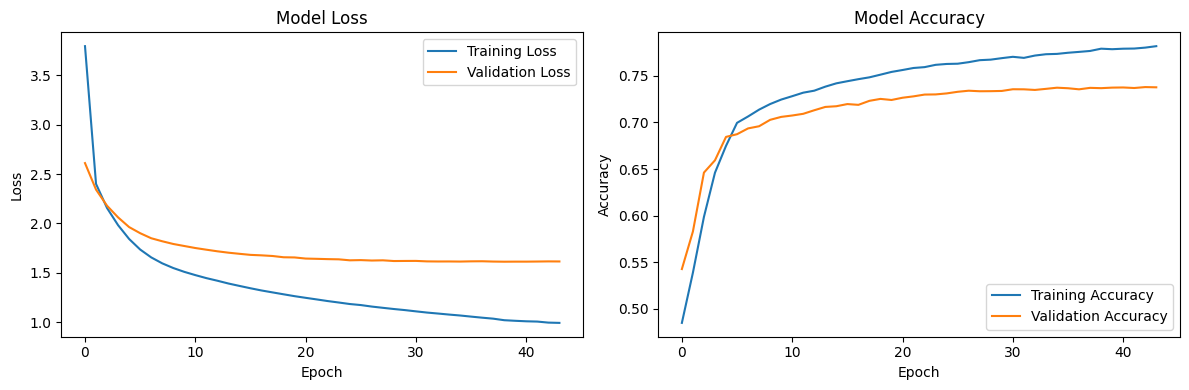

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [17]:
# Modelo del encoder para inferencia
encoder_model = Model(encoder_inputs, encoder_states)

# Modelo del decoder para inferencia
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reutilizamos las capas del decoder
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding,
                                                 initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                     [decoder_outputs] + decoder_states)

print("Modelos de inferencia creados exitosamente")

Modelos de inferencia creados exitosamente


In [29]:

def predict_response(input_text, max_response_length=8):
    # Limpiar y procesar el texto de entrada
    input_text = clean_text(input_text)

    # Convertir a secuencia
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Obtenemos los estados del encoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generamos una secuencia vacía de longitud 1
    target_seq = np.zeros((1, 1))
    # Poblar el primer carácter de la secuencia objetivo con el token de inicio
    target_seq[0, 0] = output_word2idx.get('<sos>', 0)

    # Bucle de muestreo
    stop_condition = False
    decoded_sentence = ''
    word_count = 0
    max_iterations = max_response_length

    while not stop_condition and word_count < max_iterations:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Obtener el token más probable
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = output_idx2word.get(sampled_token_index, '')

        if (sampled_word == '<eos>' or
            sampled_word == '' or
            sampled_token_index == 0 or
            word_count >= max_response_length):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
            word_count += 1

        # Actualizamos la secuencia objetivo (de longitud 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza estados
        states_value = [h, c]

    return decoded_sentence.strip() if decoded_sentence.strip() else "I don't understand"


# Esto lo agregamos para poder usar directamente la GPU y que los testeos corran con mayor velocidad
import tensorflow as tf

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detectada: {gpus[0]}")
    print("Las predicciones usarán GPU automáticamente")

    # Configurar memoria de GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memoria GPU configurada")
    except:
        print("No se pudo configurar memoria GPU")
else:
    print("GPU no detectada - usando CPU")

print("=" * 50)

# Función de predicción optimizada para GPU
@tf.function
def gpu_predict_encoder(input_seq):
    return encoder_model(input_seq)

@tf.function
def gpu_predict_decoder(decoder_input, states):
    return decoder_model([decoder_input] + states)

def predict_response_gpu(input_text, max_response_length=8):
    # Limpiar y procesar texto
    input_text = clean_text(input_text)

    # Convertir a secuencia
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Convertir a tensor para GPU
    input_seq = tf.constant(input_seq, dtype=tf.int32)

    # Obtener estados del encoder
    states_value = gpu_predict_encoder(input_seq)

    # Preparar secuencia inicial
    target_seq = tf.constant([[output_word2idx.get('<sos>', 0)]], dtype=tf.int32)

    # Variables para el bucle
    decoded_sentence = ''
    word_count = 0

    # Bucle de generación
    while word_count < max_response_length:
        output_tokens, h, c = gpu_predict_decoder(target_seq, states_value)
        states_value = [h, c]

        # Obtener token más probable
        sampled_token_index = tf.argmax(output_tokens[0, -1, :]).numpy()
        sampled_word = output_idx2word.get(sampled_token_index, '')

        if (sampled_word == '<eos>' or
            sampled_word == '' or
            sampled_token_index == 0):
            break

        decoded_sentence += ' ' + sampled_word
        word_count += 1

        # Actualiza secuencia objetivo
        target_seq = tf.constant([[sampled_token_index]], dtype=tf.int32)

    return decoded_sentence.strip() if decoded_sentence.strip() else "I don't understand"

# Función para batch processing en GPU
def gpu_batch_predict(questions, max_length=6):

    results = []

    # Procesar con GPU
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        for i, question in enumerate(questions):
            print(f"⚡ GPU procesando {i+1}/{len(questions)}: {question}")

            # Medición de tiempo
            import time
            start = time.time()

            response = predict_response_gpu(question, max_response_length=max_length)

            end = time.time()
            print(f"Respuesta ({end-start:.2f}s): {response}")

            results.append((question, response))

    return results


GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Las predicciones usarán GPU automáticamente
No se pudo configurar memoria GPU


In [30]:
# EVALUACIÓN CON GPU - SÚPER RÁPIDA ⚡
specific_questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "How are you?",
    "What is your name?",
    "Tell me about yourself",
    "What do you like to do?",
    "How old are you?"
]

print("EVALUACION")

# Verificar que estamos usando GPU
device_name = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print(f"Usando {device_name}")
print()

# Medición de tiempo total
import time
total_start = time.time()

# Usar procesamiento batch optimizado para GPU
qa_results = gpu_batch_predict(specific_questions, max_length=6)

total_end = time.time()
total_time = total_end - total_start

print("RESULTADOS")

for i, (question, response) in enumerate(qa_results, 1):
    print(f"{i}. Q: {question}")
    print(f"   A: {response}")
    print()

print(f"TIEMPO TOTAL: {total_time:.2f} segundos")
print(f"PROMEDIO POR PREGUNTA: {total_time/len(specific_questions):.2f} segundos")


EVALUACION
Usando /GPU:0

⚡ GPU procesando 1/8: Do you read?
Respuesta (1.33s): i am a vegan i am
⚡ GPU procesando 2/8: Do you have any pet?
Respuesta (0.04s): i am a vegan eos
⚡ GPU procesando 3/8: Where are you from?
Respuesta (0.04s): i am fine eos
⚡ GPU procesando 4/8: How are you?
Respuesta (0.04s): i am fine eos
⚡ GPU procesando 5/8: What is your name?
Respuesta (0.04s): i am a girl eos eos
⚡ GPU procesando 6/8: Tell me about yourself
Respuesta (0.04s): i am a girl eos eos
⚡ GPU procesando 7/8: What do you like to do?
Respuesta (0.04s): i m a student eos eos
⚡ GPU procesando 8/8: How old are you?
Respuesta (0.04s): i am fine eos
RESULTADOS
1. Q: Do you read?
   A: i am a vegan i am

2. Q: Do you have any pet?
   A: i am a vegan eos

3. Q: Where are you from?
   A: i am fine eos

4. Q: How are you?
   A: i am fine eos

5. Q: What is your name?
   A: i am a girl eos eos

6. Q: Tell me about yourself
   A: i am a girl eos eos

7. Q: What do you like to do?
   A: i m a student eos eo

En los graficos podemos ver que el aprendizaje es adecuado aunque se ve que hay overfitting leve y falta de generalización en la etapa de inferencia. Podemos ver que el modelo aprende a mapear preguntas a respuestas, pero de forma muy limitada y con muchas repeticiones y algunas sin sentido. Un ejemplo de esto son estas respuestas repetitivas (“i am a vegan”, “i am fine eos”, “i am a girl eos eos”) a preguntas muy distintas, es decir que la pregunta era sobre otra cosa. Ademas vemos que se ven tokens como “eos” al final de las respuestas, lo cual puede deberse al dataset y quizas podriamos eliminar esos tokens que no aportan valor al resultado. Aun asi, hay una pregunta que respondio bien "How are you" -> "i am fine eos", repito, estos tokens finales los podriamos limpiar con mayor tiempo, pero en este caso acerto con la respuesta. Por lo que creo que con mayor tiempo de entrenamiento, se podrian obtener mejores resultados.
